## **Import Libraries**

In [1]:
# Import necessary libraries
import pycocotools          # COCO dataset tools for object detection tasks
from ultralytics import YOLO # YOLOv5 model for object detection
import numpy as np          # Numerical computing library
import pandas as pd         # Data manipulation library
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns       # Data visualization library
import cv2                  # OpenCV library for computer vision
import os                   # Operating system functions
import yaml                 # YAML parser for configuration files
import torch                # PyTorch deep learning library
import shutil               # File operations library
import wandb                # Weights and Biases for experiment tracking
from PIL import Image       # Python Imaging Library for image processing
import glob

## **Annotation parser XML to TXT**

In [2]:
import xml.etree.ElementTree as ET

def convert_bbox_to_yolo(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

In [3]:
def parse_xml_to_yolo(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    
    yolo_annotations = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert_bbox_to_yolo((width, height), b)
        yolo_annotations.append((class_name, bb))
    return yolo_annotations


In [4]:
def save_yolo_annotations(yolo_annotations, class_mapping, output_file):
    with open(output_file, 'w') as f:
        for class_name, bbox in yolo_annotations:
            if class_name in class_mapping.keys():
                class_id = class_mapping[class_name]
                f.write(f"{class_id} {' '.join(map(str, bbox))}\n")

In [5]:
# # 2. Define label map
# label_map = {
#     "D00": 0,
#     "D01": 1,
#     "D10": 2,
#     "D11": 3,
#     "D20": 4,
#     "D40": 5,
#     "D43": 6,
#     "D44": 7,
#     "D50": 8
# }

# 2. Define label map
label_map = {
    "D00": 0,
    # "D01": 1,
    "D10": 1,
    # "D11": 3,
    "D20": 2,
    "D40": 3,
    # "D43": 6,
    # "D44": 7,
    # "D50": 8
}

In [6]:
# # 1. Set up paths and load data
# data_root_dir = "../../../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/"
# nationality = "Japan"
# mode = "train"

# image_destination_path = os.path.join(data_root_dir, nationality, nationality, mode, "images")
# annot_destination_path = os.path.join(data_root_dir, nationality, nationality, mode, "annotations/xmls") 

# # Ensure paths exist
# assert os.path.exists(image_destination_path), print("Image path not found")
# assert os.path.exists(annot_destination_path), print("Annotation path not found")

In [7]:
# annot_list = glob.glob(annot_destination_path+"/*.xml")

In [16]:
df = pd.read_csv("../../objects.csv")
df = df[(df["D00"]>0) | (df["D10"]>0) | (df["D20"]>0) | (df["D40"]>0)]
df.shape

(7900, 12)

In [17]:
from sklearn.model_selection import train_test_split
train_images_ids, test_images_ids = train_test_split(df["xml_file_path"].to_list(), test_size=0.2)

In [10]:
# dirr = "../../../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan/Japan/yolo_4_class/train/labels/"
# assert os.path.exists(dirr)
# os.path.abspath(dirr+test_images_ids[0].split("\\")[-1])

In [11]:
import tqdm

In [12]:
# dirr = "../../../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan/Japan/yolo_4_class/train/labels/"
# for annot in tqdm.tqdm(train_images_ids):
#     xml_file = os.path.abspath("../../"+annot)
#     yolo_annotations = parse_xml_to_yolo(xml_file)
#     output_file = os.path.abspath(dirr+annot.split("\\")[-1]).replace("xml","txt")
#     # output_file = xml_file.replace("xml","txt").replace("train","test")
#     save_yolo_annotations(yolo_annotations, label_map, output_file)

## **Dataset preparation**

In [43]:
# Define directory paths for dataset organization
root_dir = "../../../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan/Japan/yolo_4_class"              # Root directory containing all data
train_imgs_dir = "../../../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan/Japan/yolo_4_class/train/images"   # Directory containing training images
valid_imgs_dir = "../../../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan/Japan/yolo_4_class/test/images"    # Directory containing validation images
test_imgs_dir = "../../../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan/Japan/yolo_4_class/test/images"    # Directory containing test images
train_labels_dir = "../../../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan/Japan/yolo_4_class/train/labels" # Directory containing training labels (annotations)
valid_labels_dir = "../../../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan/Japan/yolo_4_class/test/labels"  # Directory containing validation labels (annotations)
test_labels_dir = "../../../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan/Japan/yolo_4_class/test/labels"  # Directory containing test labels (annotations)

In [14]:
os.path.exists(test_labels_dir)

True

In [15]:
# # "../../"+test_images_ids[0].replace("annotations/xmls","images").replace(".xml",".jpg")
# "../../"+test_images_ids[0].replace("annotations/xmls","images_test").replace(".xml",".jpg")

In [123]:
# import shutil

# def copy_image(source_path, destination_path):
#     """
#     Copy a single image file from source_path to destination_path.
    
#     :param source_path: Path to the source image file.
#     :param destination_path: Path to the destination where the image will be copied.
#     """
#     shutil.copy(source_path, destination_path)
#     print(f"Copied {source_path} to {destination_path}")

In [124]:
# dirr = "../../../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan/Japan/yolo_4_class/train/images/"

# for annot in tqdm.tqdm(train_images_ids):
#     source_path = "../../"+annot.replace("annotations/xmls","images").replace("xml","jpg")
#     assert os.path.exists(source_path), print("path not exists")
#     destination_path = os.path.abspath(dirr+annot.split("\\")[-1]).replace("xml","jpg")
#     copy_image(source_path, destination_path)
#     # break

In [18]:
{v:k for k,v in label_map.items()}

{0: 'D00', 1: 'D10', 2: 'D20', 3: 'D40'}

In [19]:
names = {v:k for k,v in label_map.items()}
print(names)

COLORS = np.random.uniform(0, 255, (4, 3))
print(COLORS)

{0: 'D00', 1: 'D10', 2: 'D20', 3: 'D40'}
[[     122.41      111.83       6.154]
 [     155.62      128.73      129.15]
 [     20.794      110.97      234.75]
 [     238.93      163.15      249.85]]


##  **Show samples**

In [20]:
def show_bbox(img_name, img_dir, label_dir, axis):
    """
    Display bounding boxes on an image along with class labels.

    Args:
        img_name (str): Name of the image file.
        img_dir (str): Directory containing the image file.
        label_dir (str): Directory containing label annotations.
        axis (matplotlib.axis): Axis to plot the image.

    Returns:
        None (displays the image with bounding boxes).
    """
    # Construct image path
    img_path = os.path.join(img_dir, img_name)
    
    # Read the image
    img = cv2.imread(img_path)
    
    # Convert BGR to RGB color space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get image height and width
    h, w, _ = img.shape
    
    # Create a copy of the image
    img = img.copy()
    
    try:
        # Read label file
        label_path = os.path.join(label_dir, img_name[:-4] + ".txt")
        label = pd.read_csv(label_path, sep=" ", header=None).values
        
        # Extract class labels and bounding boxes
        classes = label[:, 0]
        boxes = label[:, 1:]
        
        # Iterate over each bounding box
        for i, box in enumerate(boxes):
            cls_id = int(classes[i])
            text = names[cls_id]
            color = COLORS[cls_id]
            
            # Calculate coordinates
            xmin = int((box[0] - box[2] / 2) * w)
            ymin = int((box[1] - box[3] / 2) * h)
            xmax = int((box[0] + box[2] / 2) * w)
            ymax = int((box[1] + box[3] / 2) * h)
            
            # Draw bounding box and label
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 3)
            y = ymin - 10 if ymin - 10 > 10 else ymin + 20
            cv2.putText(img, text, (xmin, y), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 3)
    except Exception as e:
        # Print error if any
        print("Error:", e)
    
    # Display the image with bounding boxes on the specified axis
    axis.imshow(img)
    
    # Turn off axis
    axis.axis("off")

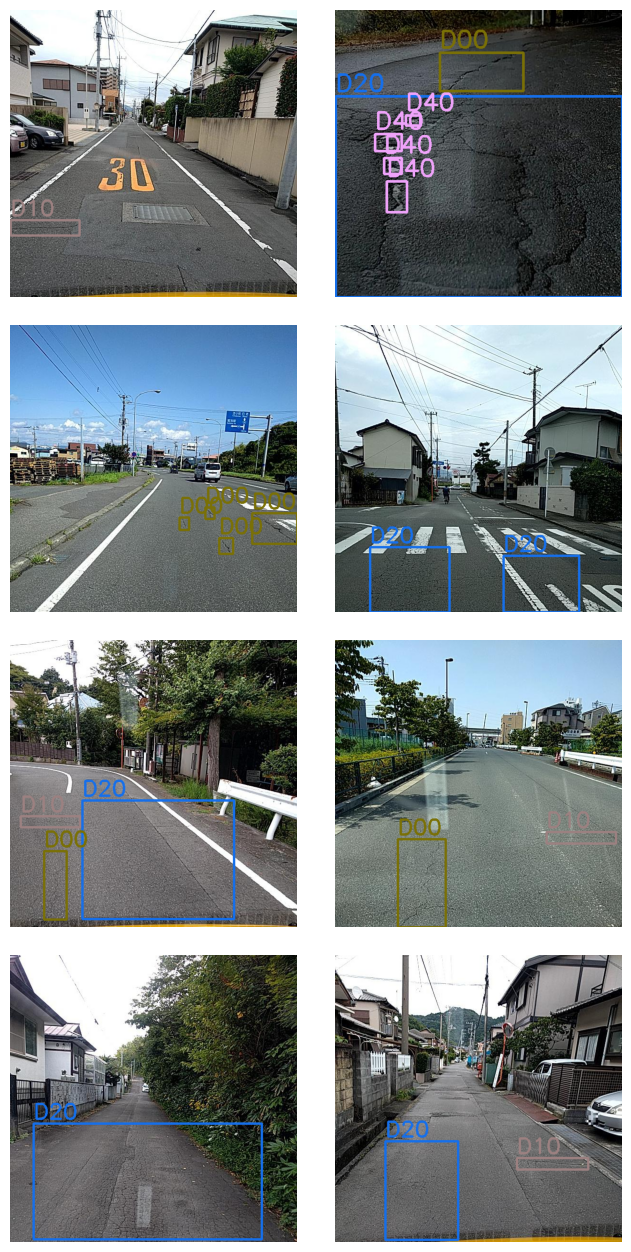

In [21]:
# Create a grid of subplots for displaying samples
fig, axes = plt.subplots(4, 2, figsize=(8, 16))

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Flatten axes array for easier iteration
ax = axes.flatten()

# Get a list of image file names from the training directory
train_img_list = sorted(os.listdir(train_imgs_dir))

# Randomly select 8 image names from the training set
img_name_list = np.random.choice(train_img_list, 8)

# Iterate over each randomly selected image name
for i, img_name in enumerate(img_name_list):
    # Display bounding boxes on the image and plot it on the corresponding axis
    show_bbox(img_name, train_imgs_dir, train_labels_dir, ax[i])

## **YOLO training**

In [22]:
# Define YOLO format dictionary for training configuration
yolo_format = {
    'path': os.path.abspath(root_dir),           # Root directory containing all data
    'train': os.path.abspath(train_imgs_dir),    # Directory containing training images
    'val': os.path.abspath(valid_imgs_dir),      # Directory containing validation images
    'nc': 4,                   # Number of classes
    'names': names              # Class names
}

# # Write YOLO format dictionary to a YAML file
# with open(root_dir+'/yolo.yaml', 'w') as outfile:
#     yaml.dump(yolo_format, outfile, default_flow_style=False)

In [132]:
# Import the Weights and Biases library
# import wandb

# Log in to Weights and Biases platform
# wandb.login(key="031db24fdc8918141763b6040d3d0a08fdf7bbe6")

In [26]:
# Instantiate YOLO object detection model
model = YOLO("C:/Users/d4rsh/OneDrive/Documents/AI - Sem 2/ML Projects/RoadSenseNew/RoadSense/training/pytorch/runs/detect/train11/weights/best.pt")
# model.resume = True

In [135]:
# Train the model
model.train(data=root_dir+"/yolo.yaml",  # Path to the YAML training configuration file
            epochs=150,     # Number of training epochs
            patience=20,    # Patience for early stopping
            batch=12,        # Batch size
            lr0=0.0003,     # Initial learning rate
            imgsz=640,      # Input image size
            freeze=6)       # Freeze layers during training

Ultralytics YOLOv8.1.35 🚀 Python-3.11.7 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)


engine\trainer: task=detect, mode=train, model=yolov8l.pt, data=../../../../project/data/RDD2022_released_through_CRDDC2022/RDD2022/Japan/Japan/yolo_4_class/yolo.yaml, epochs=150, time=None, patience=20, batch=12, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=6, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: islumang. Use `wandb login --relogin` to force relogin


Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.2.m.1.cv1.conv.weight'
Freezing layer 'model.2.m.1.cv1.bn.weight'
Freezing layer 'model.2.m.1.cv1.bn.bias'
Freezing layer 'model.2.m.1.cv2.conv.weight'
Freezing layer 'model.2.m.1.cv2.bn.weight'
Freezing layer 'model.2.m.1.cv2.bn.bias'
Freezing layer 'model.2.m.2.cv1.conv.wei

train: Scanning C:\Users\d4rsh\OneDrive\Documents\AI - Sem 2\ML Projects\project\data\RDD2022_released_through_CRDDC2022\RDD2022\Japan\Japan\yolo_4_class\train\labels...:   0%|          | 0/6320 [00:00<?, ?it/s]Scanning C:\Users\d4rsh\OneDrive\Documents\AI - Sem 2\ML Projects\project\data\RDD2022_released_through_CRDDC2022\RDD2022\Japan\Japan\yolo_4_class\train\labels... 10 images, 0 backgrounds, 0 corrupt:   0%|          | 10/6320 [00:00<01:08, 92.66it/s]Scanning C:\Users\d4rsh\OneDrive\Documents\AI - Sem 2\ML Projects\project\data\RDD2022_released_through_CRDDC2022\RDD2022\Japan\Japan\yolo_4_class\train\labels... 33 images, 0 backgrounds, 0 corrupt:   1%|          | 33/6320 [00:00<00:43, 143.82it/s]Scanning C:\Users\d4rsh\OneDrive\Documents\AI - Sem 2\ML Projects\project\data\RDD2022_released_through_CRDDC2022\RDD2022\Japan\Japan\yolo_4_class\train\labels... 51 images, 0 backgrounds, 0 corrupt:   1%|          | 51/6320 [00:00<00:40, 156.16it/s]Scanning C:\Users\d4rsh\OneDrive\Documen

train: New cache created: C:\Users\d4rsh\OneDrive\Documents\AI - Sem 2\ML Projects\project\data\RDD2022_released_through_CRDDC2022\RDD2022\Japan\Japan\yolo_4_class\train\labels.cache


val: Scanning C:\Users\d4rsh\OneDrive\Documents\AI - Sem 2\ML Projects\project\data\RDD2022_released_through_CRDDC2022\RDD2022\Japan\Japan\yolo_4_class\test\labels...:   0%|          | 0/1580 [00:00<?, ?it/s]Scanning C:\Users\d4rsh\OneDrive\Documents\AI - Sem 2\ML Projects\project\data\RDD2022_released_through_CRDDC2022\RDD2022\Japan\Japan\yolo_4_class\test\labels... 17 images, 0 backgrounds, 0 corrupt:   1%|          | 17/1580 [00:00<00:10, 155.29it/s]Scanning C:\Users\d4rsh\OneDrive\Documents\AI - Sem 2\ML Projects\project\data\RDD2022_released_through_CRDDC2022\RDD2022\Japan\Japan\yolo_4_class\test\labels... 41 images, 0 backgrounds, 0 corrupt:   3%|▎         | 41/1580 [00:00<00:08, 177.16it/s]Scanning C:\Users\d4rsh\OneDrive\Documents\AI - Sem 2\ML Projects\project\data\RDD2022_released_through_CRDDC2022\RDD2022\Japan\Japan\yolo_4_class\test\labels... 59 images, 0 backgrounds, 0 corrupt:   4%|▎         | 59/1580 [00:00<00:09, 154.18it/s]Scanning C:\Users\d4rsh\OneDrive\Documents\AI

val: New cache created: C:\Users\d4rsh\OneDrive\Documents\AI - Sem 2\ML Projects\project\data\RDD2022_released_through_CRDDC2022\RDD2022\Japan\Japan\yolo_4_class\test\labels.cache
Plotting labels to runs\detect\train11\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0003' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.00046875), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train11
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      3.99G      2.037      2.971      1.951         25        640: 100%|██████████| 527/527 [05:35<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


                   all       1580       3289      0.331      0.326      0.257      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      4.34G      1.888       2.22      1.759         31        640: 100%|██████████| 527/527 [05:17<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


                   all       1580       3289      0.363      0.334      0.286      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      4.34G      1.954      2.285      1.833         41        640: 100%|██████████| 527/527 [05:16<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.07it/s]


                   all       1580       3289      0.328      0.316      0.247      0.095

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      4.13G      1.989      2.336      1.876         24        640: 100%|██████████| 527/527 [05:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.07it/s]


                   all       1580       3289      0.334      0.343      0.285      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      4.12G       1.95      2.245      1.851         19        640: 100%|██████████| 527/527 [05:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.07it/s]


                   all       1580       3289      0.402       0.35      0.322      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      4.34G      1.916      2.161      1.822         25        640: 100%|██████████| 527/527 [05:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.431      0.362      0.361      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      4.36G      1.884      2.118      1.785         20        640: 100%|██████████| 527/527 [05:09<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.07it/s]


                   all       1580       3289      0.384      0.405      0.361      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      4.35G      1.865      2.056      1.768         33        640: 100%|██████████| 527/527 [05:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.412      0.404      0.375      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      4.36G      1.844      2.017      1.749         24        640: 100%|██████████| 527/527 [05:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.07it/s]


                   all       1580       3289      0.402      0.423      0.372      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      4.36G       1.82      1.989      1.739         32        640: 100%|██████████| 527/527 [05:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.07it/s]


                   all       1580       3289      0.436      0.432      0.396       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      4.34G      1.813      1.965       1.72         23        640: 100%|██████████| 527/527 [05:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.441      0.437      0.407      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      4.34G      1.795      1.944       1.71         31        640: 100%|██████████| 527/527 [05:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.472      0.421      0.417      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      4.35G      1.776      1.904      1.705         38        640: 100%|██████████| 527/527 [05:09<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.07it/s]


                   all       1580       3289      0.486      0.446      0.429      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150       4.1G      1.777      1.871      1.698         22        640: 100%|██████████| 527/527 [04:57<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.487      0.446      0.435      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      4.35G      1.758      1.861      1.695         35        640: 100%|██████████| 527/527 [04:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.10it/s]


                   all       1580       3289      0.475      0.473       0.45      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      4.11G      1.744       1.85      1.688         28        640: 100%|██████████| 527/527 [04:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.477      0.461      0.452      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      4.34G      1.749      1.838      1.689         23        640: 100%|██████████| 527/527 [04:43<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.481      0.453      0.434      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      4.34G      1.739      1.809      1.674         22        640: 100%|██████████| 527/527 [04:42<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.10it/s]


                   all       1580       3289      0.474      0.475      0.456      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      4.35G       1.73      1.795      1.664         29        640: 100%|██████████| 527/527 [04:42<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.478      0.474       0.45      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      4.34G      1.713      1.781      1.653         27        640: 100%|██████████| 527/527 [04:42<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.10it/s]


                   all       1580       3289      0.508      0.462      0.458      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      4.34G      1.707      1.749      1.645         18        640: 100%|██████████| 527/527 [04:43<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.491      0.476      0.466      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      4.34G      1.685      1.716      1.629         23        640: 100%|██████████| 527/527 [04:43<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.508      0.476      0.471      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      4.11G       1.69      1.715      1.635         37        640: 100%|██████████| 527/527 [04:42<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.477      0.492      0.469      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150       4.1G      1.687      1.697      1.621         37        640: 100%|██████████| 527/527 [04:51<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.483      0.486      0.467      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      4.34G      1.675      1.683      1.626         50        640: 100%|██████████| 527/527 [05:01<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.518       0.48      0.473      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      4.33G      1.671      1.678      1.623         19        640: 100%|██████████| 527/527 [04:54<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.523      0.475      0.488       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      4.34G      1.664      1.661      1.607         31        640: 100%|██████████| 527/527 [04:43<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.507      0.497      0.487      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      4.34G      1.661      1.642      1.608         29        640: 100%|██████████| 527/527 [04:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.518      0.496      0.488      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      4.33G      1.641      1.622      1.604         25        640: 100%|██████████| 527/527 [04:44<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.10it/s]


                   all       1580       3289      0.518      0.488      0.491      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      4.35G      1.643      1.623      1.595         18        640: 100%|██████████| 527/527 [04:43<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.488      0.509       0.49      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      4.11G      1.632      1.613      1.589         21        640: 100%|██████████| 527/527 [04:43<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.506      0.491      0.477      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      4.35G      1.624      1.581      1.583         20        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.518      0.498      0.493      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      4.34G      1.618      1.566      1.574         26        640: 100%|██████████| 527/527 [04:42<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.541      0.482      0.486      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150       4.1G      1.605      1.542      1.568         24        640: 100%|██████████| 527/527 [04:42<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289       0.53      0.497       0.49      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      4.11G      1.599      1.539      1.564         28        640: 100%|██████████| 527/527 [04:42<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.515      0.512       0.49      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      4.35G      1.604      1.536      1.566         29        640: 100%|██████████| 527/527 [04:42<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289       0.52      0.511      0.501      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      4.35G      1.589       1.52      1.556         15        640: 100%|██████████| 527/527 [04:45<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.556      0.482        0.5      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      4.33G      1.577      1.492      1.553         31        640: 100%|██████████| 527/527 [04:42<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.518      0.501      0.488      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      4.35G      1.579      1.505      1.547         20        640: 100%|██████████| 527/527 [04:42<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.532      0.496      0.495      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      4.35G      1.567      1.465      1.534         21        640: 100%|██████████| 527/527 [04:43<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.557      0.492      0.512      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      4.12G      1.555      1.458      1.523         22        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.528      0.513       0.51      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      4.33G      1.549      1.434      1.522         31        640: 100%|██████████| 527/527 [04:43<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.526       0.52      0.511      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150       4.1G      1.546      1.422      1.519         34        640: 100%|██████████| 527/527 [04:43<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.527      0.502      0.494      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      4.33G      1.524      1.405      1.508         30        640: 100%|██████████| 527/527 [04:42<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289        0.5      0.525        0.5       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      4.34G      1.534      1.392      1.516         20        640: 100%|██████████| 527/527 [04:43<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.544      0.514      0.511      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      4.33G       1.52      1.385      1.503         18        640: 100%|██████████| 527/527 [04:42<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.543      0.512      0.511      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      4.34G      1.515      1.369      1.491         31        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.549      0.511      0.506      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      4.33G      1.502      1.354      1.486         27        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.548      0.512      0.512      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      4.34G      1.495      1.348      1.479         32        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.562      0.495      0.504      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      4.11G      1.488      1.319      1.477         15        640: 100%|██████████| 527/527 [04:42<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.549       0.52      0.511      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      4.34G      1.482      1.317      1.471         22        640: 100%|██████████| 527/527 [04:42<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.548      0.516      0.511      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      4.34G      1.483      1.305      1.472         31        640: 100%|██████████| 527/527 [04:42<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.556      0.517      0.515      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      4.11G      1.476      1.293      1.466         20        640: 100%|██████████| 527/527 [04:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.571      0.507      0.513      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      4.34G      1.465      1.293      1.461         24        640: 100%|██████████| 527/527 [04:42<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.541      0.525      0.513      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      4.35G      1.453      1.265      1.449         21        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.555      0.515      0.516      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      4.33G      1.449      1.264      1.441         28        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.545      0.506      0.508      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      4.34G      1.448      1.252      1.448         16        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.571      0.504      0.515      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      4.35G      1.435      1.232      1.431         20        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.546      0.522      0.511      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      4.34G      1.433      1.228      1.436         22        640: 100%|██████████| 527/527 [04:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.573      0.502      0.513      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      4.34G      1.421      1.209      1.431         25        640: 100%|██████████| 527/527 [04:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.554      0.513      0.511      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      4.35G      1.407      1.198      1.422         47        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.553      0.517      0.509      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      4.34G      1.407      1.191      1.419         24        640: 100%|██████████| 527/527 [04:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.548      0.514      0.508      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      4.09G      1.386      1.172      1.406         24        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.564      0.495      0.506      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      4.33G      1.387      1.163      1.398         40        640: 100%|██████████| 527/527 [04:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.541      0.509      0.512      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      4.35G      1.391      1.157      1.406         20        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.555      0.508      0.511      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150       4.1G      1.375      1.136      1.392         31        640: 100%|██████████| 527/527 [04:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.556      0.508      0.511      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      4.34G      1.366       1.13      1.383         22        640: 100%|██████████| 527/527 [04:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.552      0.514      0.507      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      4.34G      1.362      1.119      1.384         27        640: 100%|██████████| 527/527 [04:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289       0.56      0.519      0.514      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      4.33G      1.359      1.119       1.38         16        640: 100%|██████████| 527/527 [04:41<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289       0.59      0.495      0.516      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      4.35G      1.347        1.1      1.369         18        640: 100%|██████████| 527/527 [04:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.546      0.523      0.516      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      4.33G      1.346      1.113      1.374         24        640: 100%|██████████| 527/527 [04:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.564      0.509       0.51      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      4.34G       1.34      1.084      1.363         23        640: 100%|██████████| 527/527 [04:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.548      0.518      0.506      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      4.33G      1.337      1.085      1.364         38        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.10it/s]


                   all       1580       3289      0.578      0.476      0.507      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      4.33G      1.327      1.075      1.362         16        640: 100%|██████████| 527/527 [04:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.583      0.495      0.511      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      4.11G      1.305      1.057      1.345         22        640: 100%|██████████| 527/527 [04:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.548      0.523      0.518      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      4.34G       1.31      1.044      1.345         31        640: 100%|██████████| 527/527 [04:37<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.568       0.52      0.522      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      4.51G        1.3      1.054       1.34         31        640: 100%|██████████| 527/527 [04:37<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.576      0.513      0.515      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      4.34G      1.289      1.023      1.334         23        640: 100%|██████████| 527/527 [04:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.10it/s]


                   all       1580       3289      0.553      0.512      0.509      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      4.34G      1.283      1.012      1.332         14        640: 100%|██████████| 527/527 [04:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.558      0.515      0.511      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150       4.1G      1.283      1.017      1.328         28        640: 100%|██████████| 527/527 [04:38<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.587      0.493      0.508      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      4.11G      1.269     0.9992      1.318         29        640: 100%|██████████| 527/527 [04:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.583      0.498      0.513      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      4.34G      1.269     0.9955      1.316         29        640: 100%|██████████| 527/527 [04:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.563      0.515      0.513      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      4.35G      1.265     0.9934      1.316         32        640: 100%|██████████| 527/527 [04:37<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.562      0.505      0.514      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      4.33G      1.255     0.9818       1.31         17        640: 100%|██████████| 527/527 [04:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.589      0.492      0.511      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150       4.1G      1.248     0.9752      1.301         39        640: 100%|██████████| 527/527 [04:38<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289       0.58      0.488      0.511      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      4.33G       1.25     0.9734      1.305         31        640: 100%|██████████| 527/527 [04:37<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.586      0.492      0.512      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      4.33G      1.239     0.9594      1.292         23        640: 100%|██████████| 527/527 [04:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.583      0.495      0.507       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      4.35G      1.226     0.9338      1.291         28        640: 100%|██████████| 527/527 [04:37<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289       0.58      0.496      0.507       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      4.35G      1.221       0.94       1.28         33        640: 100%|██████████| 527/527 [04:39<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.563      0.514      0.508      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      4.33G      1.216     0.9364      1.281         22        640: 100%|██████████| 527/527 [04:37<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.583      0.507       0.51      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      4.33G      1.203     0.9175      1.271         28        640: 100%|██████████| 527/527 [04:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.581      0.495      0.505      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      4.34G      1.209     0.9156      1.274         31        640: 100%|██████████| 527/527 [04:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.559      0.508      0.507      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      4.34G      1.194     0.9086      1.264         55        640: 100%|██████████| 527/527 [04:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.553       0.51      0.503      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150       4.1G      1.188     0.8934      1.266         27        640: 100%|██████████| 527/527 [04:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


                   all       1580       3289      0.537      0.516      0.497      0.223

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      4.09G      1.187     0.8985      1.264         30        640: 100%|██████████| 527/527 [04:36<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289      0.562      0.493        0.5      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      4.33G       1.17      0.878      1.253         32        640: 100%|██████████| 527/527 [04:40<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]


                   all       1580       3289      0.564      0.504      0.503      0.225
Stopping training early as no improvement observed in last 20 epochs. Best results observed at epoch 76, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

96 epochs completed in 9.274 hours.
Optimizer stripped from runs\detect\train11\weights\last.pt, 87.7MB
Optimizer stripped from runs\detect\train11\weights\best.pt, 87.7MB

Validating runs\detect\train11\weights\best.pt...
Ultralytics YOLOv8.1.35 🚀 Python-3.11.7 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Model summary (fused): 268 layers, 43609692 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


                   all       1580       3289       0.57      0.517      0.522      0.237
                   D00       1580        799      0.544      0.467      0.467        0.2
                   D10       1580        749      0.477      0.425      0.384      0.144
                   D20       1580       1318      0.643      0.647      0.663      0.331
                   D40       1580        423      0.615       0.53      0.572      0.273
Speed: 0.3ms preprocess, 34.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\train11


lr/pg0,▁████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂
lr/pg1,▁████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂
lr/pg2,▁████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂
metrics/mAP50(B),▁▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇█▇████████████████████▇
metrics/mAP50-95(B),▂▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇████████████████████▇▇▇
metrics/precision(B),▁▁▃▃▄▅▅▅▆▆▆▆▅▆▆▇▆▆▆▇▇▇▇▇█▇▇▇█▇█▇▇█▇███▇▇
metrics/recall(B),▁▁▂▄▅▅▆▆▆▆▆▇▇▇█▇▇███▇██▇▇█▇▇▇▇▇██▇▇▇▇▇▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E29E533610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

## **IoU Scoring**

In [42]:
# Function to compute IoU
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    
    union = box1_area + box2_area - intersection
    iou = intersection / union
    
    return iou

In [46]:
val_images = [os.path.join(valid_imgs_dir, img) for img in os.listdir(valid_imgs_dir) if img.endswith(('.jpg'))]

In [65]:
# Dictionary to store predictions and IoUs
predictions = {}
ious_dict = {}

In [67]:
for img_path in tqdm.tqdm(val_images):
    # Load image
    image = cv2.imread(img_path)
    
    # Run inference
    results = model(image)
    print(results[0].boxes.xyxyn)
    # break
    
    # Predicted boxes: results.pred[0] contains the predicted bounding boxes
    # pred_boxes = results.pred[0][:, :4].cpu().numpy()  # Extract the bounding box coordinates
    pred_boxes = results[0].boxes.xyxyn.cpu().numpy()
    # Example ground truth boxes (replace with actual ground truth for each image)
    label_file = os.path.join(valid_labels_dir, os.path.basename(img_path).replace('.jpg', '.txt'))
    ground_truth_boxes = []
    
    with open(label_file, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split()
            x_center, y_center, width, height = map(float, parts[1:])
            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x_center + width / 2
            y2 = y_center + height / 2
            ground_truth_boxes.append([x1, y1, x2, y2])
    
    ground_truth_boxes = np.array(ground_truth_boxes)
    # print(ground_truth_boxes)
    # Calculate IoU for each predicted box with each ground truth box
    ious = np.zeros((len(pred_boxes), len(ground_truth_boxes)))
    
    for i, pred_box in enumerate(pred_boxes):
        for j, gt_box in enumerate(ground_truth_boxes):
            ious[i, j] = compute_iou(pred_box, gt_box)
    
    predictions[img_path] = pred_boxes
    ious_dict[img_path] = ious

In [80]:
np.mean([i.mean() for i in ious_dict.values() if i.mean() >= 0])

C:\Users\d4rsh\AppData\Local\Temp\ipykernel_38000\3654097028.py:1: RuntimeWarning: Mean of empty slice.
  np.mean([i.mean() for i in ious_dict.values() if i.mean() >= 0])
c:\Users\d4rsh\.conda\envs\torchpy\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.7356241440067319